In [11]:
from model import Unet

In [12]:
unet = Unet()
model = unet.initial_model()

Initial U-Net model


In [13]:
model .summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 572, 572, 1)  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 570, 570, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 568, 568, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
maxpooling_1 (MaxPooling2D)     (None, 284, 284, 64) 0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

In [ ]:
image_path = "data/data1/aug-patch/"
mask_path = "data/data1/aug-patch/"
image_prefix = "image"
mask_prefix = "mask"
image_as_gray = True
mask_as_gray = True
image_name_arr = glob.glob(os.path.join(image_path,"*%s*.png"%image_prefix))
image_arr = []
mask_arr = []
for index,item in enumerate(image_name_arr):
    img = io.imread(item,as_gray = image_as_gray)
    img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
    mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
    mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
#     img,mask = adjustData(img,mask,flag_multi_class,num_class)
    image_arr.append(img)
    mask_arr.append(mask)
image_arr = np.array(image_arr)
mask_arr = np.array(mask_arr)

In [ ]:
np.save('image_array_model', image_arr)

In [ ]:
tmp_mask = list()
for mask in mask_arr:
    tmp_mask.append(mask[92:480, 92:480])
tmp_mask = np.array(tmp_mask)
tmp_mask.shape

In [ ]:
np.save('mask_array_model', tmp_mask)

In [4]:
import numpy as np
image_arr = np.load('image_array_model.npy')
tmp_mask = np.load('mask_array_model.npy')

In [5]:
import keras.backend as K
def iou_loss_score(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)
    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

In [15]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = [iou_loss_score])

In [8]:
results = model.fit(image_arr, tmp_mask, batch_size=1, epochs=10, verbose=1)

Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[1,128,392,392] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node skip_connection4/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _class=["loc:@training/Adam/gradients/skip_connection4/concat_grad/Slice"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](upsampling4/BiasAdd, cropped_conv1_2/strided_slice, training/Adam/gradients/loss/conv10_loss/Mean_3_grad/Maximum)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss/mul/_439}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2858_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [17]:
model.load_weights('model_weights_150.h5')

In [20]:
inference_image = model.predict(image_arr, batch_size=1)

In [22]:
inference_image[0].shape

(388, 388, 1)

In [24]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

def image_preview(data, cmap_status=True):
    if cmap_status:
        plt.imshow(data, cmap=plt.get_cmap('bone'))
        plt.colorbar()
    else:
        plt.imshow(data)
        plt.colorbar()

(572, 572)


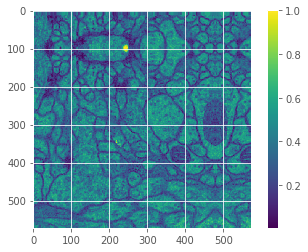

In [33]:
preview_x = image_arr[0][:,:,0]
image_preview(preview_x, cmap_status=False)
print(preview_x.shape)

(388, 388)


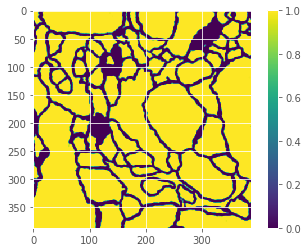

In [34]:
preview_y = inference_image[0][:,:,0]
image_preview(preview_y, cmap_status=False)
print(preview_y.shape)

In [39]:
import gc

K.clear_session()
gc.collect()

113